In [1]:
import matplotlib
import cv2
import os
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pathlib

Using TensorFlow backend.


In [150]:
from PIL import Image
data = []
labels = []
random.seed(1234)

#берём пути к изображениям и рандомно перемешиваем
data_root = pathlib.Path("C:\\UIR\\samples\\sample_2\\2250\\cut_letters")
imagePaths = list(data_root.glob('*/*'))
imagePaths = [str(path) for path in imagePaths]
random.shuffle(imagePaths)

#цикл по изображениям
for imagePath in imagePaths:
    #загружаем изображение, меняем размер на 28x28 пикселей и добавляем в список
    image = cv2.imread(imagePath)
    image = cv2.resize(image,(28,28))
    data.append(image)
    
    #извлекаем метку класса из пути к изображению и обновляем список меток
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [151]:
# масштабируем интенсивности пикселей из диапазона [0,255] -> в диапазон [0, 1]
data = np.array(data,dtype="float") / 255.0
labels = np.array(labels)

In [152]:
# разбиваем данные на обучающую и тестовую выборки, используя 75% 
# данных для обучения и оставшиеся 25% для тестирования
(trainX,testX, trainY,testY) = train_test_split(data, labels, test_size = 0.25, random_state = 42)
print(testX.shape)
print(trainX.shape)

(21000, 28, 28, 3)
(63000, 28, 28, 3)


In [153]:
#Конвертируем метки из целых чисел в векторы
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY) #находит все уникальные метки класса в testY, а затем преобразует их в метки One-Hot Encoding
testY = lb.transform(testY) #выполняет один шаг One-Hot Encoding исходя из найденных уникальных меток на предыдущем шаге

In [154]:
print('X_train shape:', trainX.shape)
print(trainX.shape[0], 'train samples')
print(testX.shape[0], 'test samples')

X_train shape: (63000, 28, 28, 3)
63000 train samples
21000 test samples


In [130]:
def show_ex(itt):
    image = trainX[itt]
    cv2.imshow('image',image)
    cv2.waitKey(0)
    print(trainY[itt])

    
#show_ex(5)

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## CNN Architecture

In [175]:
EPOCHS = 7
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 3) #input_shape будет равен 28x28x3
num_classes = 28


model = Sequential()
model.add(Conv2D(filters=70,kernel_size=(3, 3),strides=(1, 1), activation='sigmoid', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='same'))

model.add(Conv2D(filters=100,kernel_size=(3, 3),strides=(1, 1), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2))

model.add(Conv2D(filters=150,kernel_size=(3, 3),strides=(1, 1), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2))

model.add(Flatten())
model.add(Dense(300, activation='sigmoid'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

#Компилируем модель, используя adadelta как оптимизатор и категориальную
# кросс-энтропию в качестве функции потерь. Добавляем метрики
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [176]:
#отобразим получившуюся модель
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 26, 26, 70)        1960      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 13, 13, 70)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 11, 11, 100)       63100     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 5, 5, 100)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 3, 3, 150)         135150    
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 1, 1, 150)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 150)             

In [177]:
#подключаем колбаски для работы tensorboard
#write tensorboard --logdir C:/UIR/network_2_25/logs in cmd

from keras import callbacks
checkpoint_filepath = 'C:\\UIR\\network_2_25\\checkpoints'

my_callbacks = [
    # This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs.
    #callbacks.EarlyStopping(monitor='val_loss', patience=3), #возможно val_loss -> loss
    #callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=False,monitor='val_acc',mode='max',save_best_only=True),
    #callbacks.TensorBoard(log_dir="C:\\UIR\\network_2_25\\logs", histogram_freq = 1, write_graph = True, write_images = True)
]
# The model weights (that are considered the best) are loaded into the model.
#model.load_weights(checkpoint_filepath)

In [178]:
H = model.fit(trainX, trainY, verbose=2, validation_data=(testX, testY), epochs=EPOCHS, batch_size=32, callbacks=my_callbacks)

Train on 63000 samples, validate on 21000 samples
Epoch 1/7
 - 93s - loss: 3.3484 - accuracy: 0.0357 - val_loss: 3.3333 - val_accuracy: 0.0349
Epoch 2/7
 - 92s - loss: 3.3331 - accuracy: 0.0347 - val_loss: 3.3323 - val_accuracy: 0.0358
Epoch 3/7
 - 95s - loss: 3.3327 - accuracy: 0.0350 - val_loss: 3.3324 - val_accuracy: 0.0346
Epoch 4/7
 - 95s - loss: 3.3327 - accuracy: 0.0342 - val_loss: 3.3326 - val_accuracy: 0.0343
Epoch 5/7
 - 104s - loss: 3.3326 - accuracy: 0.0338 - val_loss: 3.3326 - val_accuracy: 0.0353
Epoch 6/7
 - 101s - loss: 3.3327 - accuracy: 0.0342 - val_loss: 3.3324 - val_accuracy: 0.0350
Epoch 7/7
 - 101s - loss: 3.3326 - accuracy: 0.0348 - val_loss: 3.3324 - val_accuracy: 0.0343


In [184]:
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(trainX[5].reshape(1,28,28,3))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1
        

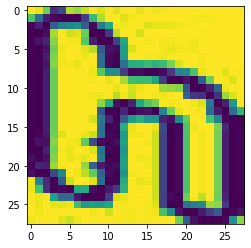

In [183]:
plt.imshow(trainX[5][:,:,0]);

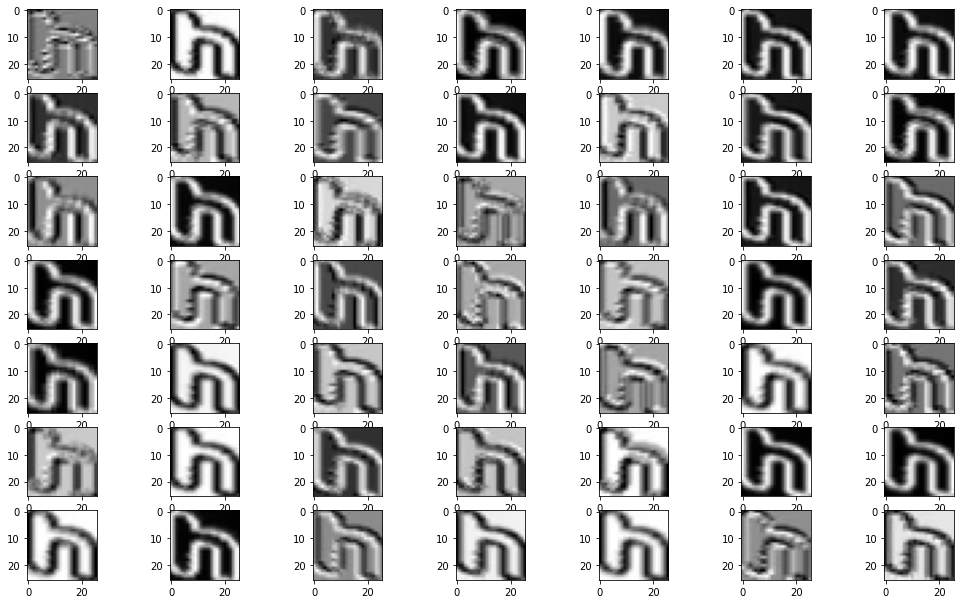

In [185]:
display_activation(activations, 7, 7, 0) #Desplaying above image after layer 1

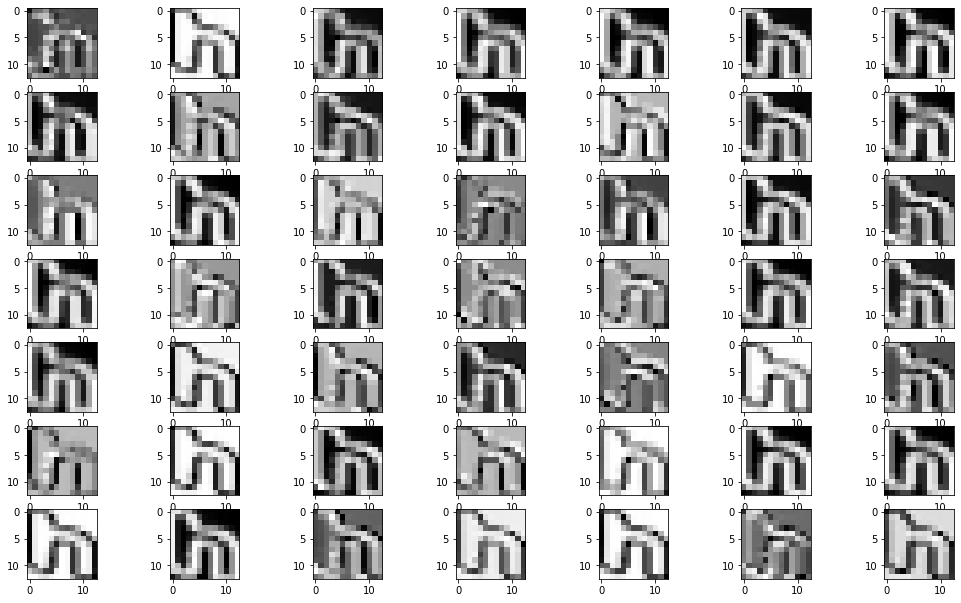

In [186]:
display_activation(activations, 7, 7, 1) #Desplaying above image after layer 2

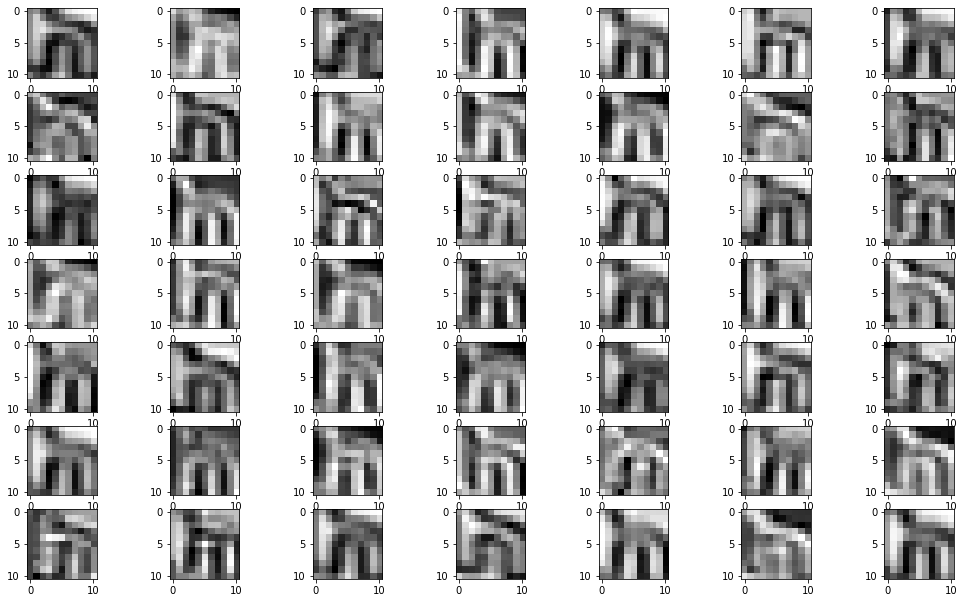

In [187]:
display_activation(activations, 7, 7, 2) #Desplaying above image after layer 3

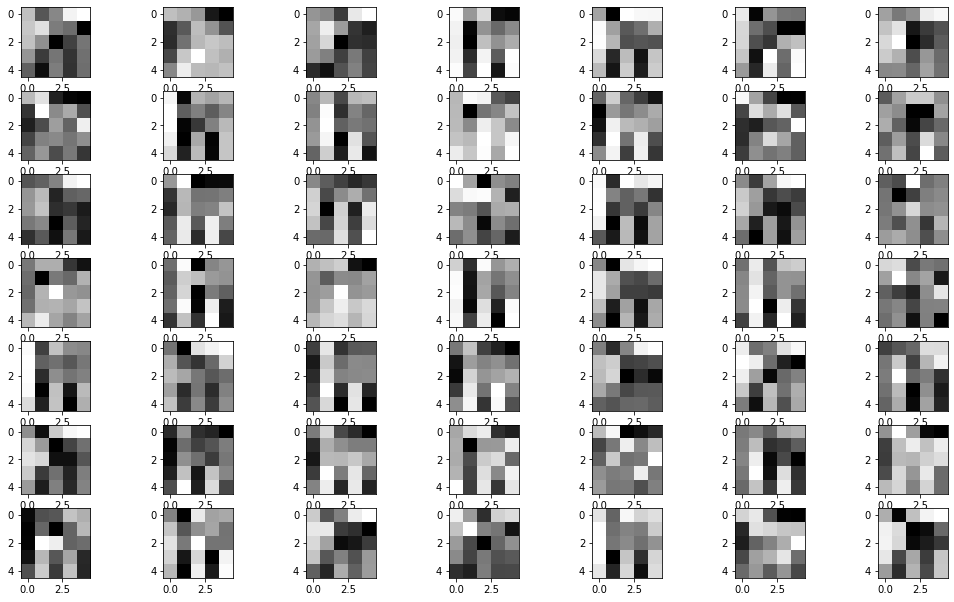

In [188]:
display_activation(activations, 7, 7, 3) #Desplaying above image after layer 4

In [ ]:
model.save('model_2_25.h5')
f = open("C:\\UIR\\network_2_25\\bin_class.txt", "wb")
f.write(pickle.dumps(lb))
f.close()

In [103]:
itt = 1
image = data[itt]
cv2.imshow('image',image)
cv2.waitKey(0)
print(labels[itt])


i
